In [1]:
from IPython.display import display, HTML, FileLink
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from baseball_id import Lookup
from scipy.stats import gaussian_kde
from sportypy.surfaces.baseball import MLBField


plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'

In [3]:
statcast_2023 = pd.read_csv('statcast_2023_season.csv', low_memory=False)
statcast_2024 = pd.read_csv('statcast_2024_season.csv', low_memory=False)

statcast_2023['Season'] = 2023
statcast_2024['Season'] = 2024

statcast_all = pd.concat([statcast_2023, statcast_2024], ignore_index=True)

In [4]:
fb = statcast_all[statcast_all['des'].str.contains('first baseman', case=False, na=False)].copy()

fb_counts = fb['fielder_3'].value_counts()
fb = fb[fb['fielder_3'].isin(fb_counts[fb_counts >= 200].index)].copy()

successful_events = {
    'field_out', 'sac_fly', 'force_out', 'grounded_into_double_play', 'double_play',
    'fielders_choice_out', 'sac_bunt', 'sac_fly_double_play', 'triple_play'
}
unsuccessful_events = {'single', 'field_error', 'double', 'triple'}

def classify_event(evt):
    if   evt in successful_events:   return 1
    elif evt in unsuccessful_events: return 0
    else:                            return pd.NA

fb['fielding_success'] = fb['events'].map(classify_event)
fb.dropna(subset=['fielding_success'], inplace=True)

ids = fb['fielder_3'].astype(int).unique()
lookup = Lookup.from_mlb_ids(ids)
fb = fb.merge(
    lookup[['mlb_id','mlb_name']],
    left_on='fielder_3', right_on='mlb_id',
    how='left'
).rename(columns={'mlb_name':'Player'})
fb = fb.loc[:, ~fb.columns.duplicated()]

In [5]:
def plot_1b_play_heatmap(
    df,
    selected_player,
    outcome='successful',
    mesh_size=200,
    grid_n=5,
    grid_color='white',
    grid_linewidth=0.8
):
    df1 = df[df['hit_location']==3].dropna(subset=['hc_x','hc_y']).copy()

    if outcome=='successful':
        df_out = df1[df1['events'].isin(successful_events)]
    elif outcome=='unsuccessful':
        df_out = df1[df1['events'].isin(unsuccessful_events)]
    else:
        raise ValueError("outcome must be 'successful' or 'unsuccessful'")
    if df_out.empty:
        raise ValueError(f"No {outcome} plays at 1B in your data.")

    x_all = 2.5*(df_out['hc_x'] - 125.42)
    y_all = 2.5*(198.27 - df_out['hc_y'])
    xy_all = np.vstack([x_all, y_all])
    mask_all = np.isfinite(xy_all).all(axis=0)
    kde_all  = gaussian_kde(xy_all[:,mask_all])

    player_df = df_out[df_out['Player']==selected_player]
    if player_df.empty:
        raise ValueError(f"No {outcome} plays for {selected_player!r}.")
    x_pl = 2.5*(player_df['hc_x'] - 125.42)
    y_pl = 2.5*(198.27 - player_df['hc_y'])
    xy_pl = np.vstack([x_pl, y_pl])
    mask_pl = np.isfinite(xy_pl).all(axis=0)
    kde_pl   = gaussian_kde(xy_pl[:,mask_pl])

    xmin, xmax = -70, 180
    ymin, ymax = -20, 170
    
    X, Y = np.mgrid[xmin:xmax:mesh_size*1j,
                    ymin:ymax: mesh_size*1j]
    pts = np.vstack([X.ravel(), Y.ravel()])
    Z_all = kde_all(pts).reshape(X.shape)
    Z_pl  = kde_pl (pts).reshape(X.shape)
    Z_all /= Z_all.max()
    Z_pl  /= Z_pl .max()
    Z_diff = Z_pl - Z_all

    mlb = MLBField(color_updates={
      "plot_background":"#none","infield_dirt":"none",
      "infield_grass":"none","pitchers_mound":"none",
      "base":"gray","pitchers_plate":"gray",
      "batters_box":"gray","catchers_box":"gray",
      "foul_line":"gray","running_lane":"gray"
    })
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,6))

    ax0.pcolormesh(X,Y,Z_all,cmap='gist_heat',shading='auto')
    mlb.draw(ax=ax0)
    ax0.set_title(f"League‑wide {outcome.capitalize()} Density")
    ax0.set(xlim=(xmin,xmax), ylim=(ymin,ymax))
    ax0.axis('off')

    pcm = ax1.pcolormesh(
        X,Y,Z_diff,
        cmap='berlin', shading='auto',
        vmin=-Z_diff.max(), vmax=Z_diff.max()
    )
    
    mlb.draw(ax=ax1)
    
    ax1.set_title(f"{selected_player}\n{outcome.capitalize()} Δ")
    ax1.set(xlim=(xmin,xmax), ylim=(ymin,ymax))
    ax1.axis('off')

    x_edges = np.linspace(xmin,xmax, grid_n+1)
    y_edges = np.linspace(ymin,ymax, grid_n+1)
    
    for xe in x_edges: ax1.axvline(xe, color=grid_color, lw=grid_linewidth, zorder=3)
    for ye in y_edges: ax1.axhline(ye, color=grid_color, lw=grid_linewidth, zorder=3)

    for i in range(grid_n):
        for j in range(grid_n):
            x0,x1 = x_edges[i],   x_edges[i+1]
            y0,y1 = y_edges[j],   y_edges[j+1]
            cnt = ((x_pl>=x0)&(x_pl< x1)&(y_pl>=y0)&(y_pl< y1)).sum()
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            ax1.text(xc,yc, str(cnt),
                ha='center',va='center',
                color=grid_color, fontsize=9, zorder=4)

    fig.colorbar(pcm, ax=ax1, fraction=0.046, pad=0.04, label=f"{outcome.capitalize()} (player − league)")
    plt.tight_layout()
    plt.show()

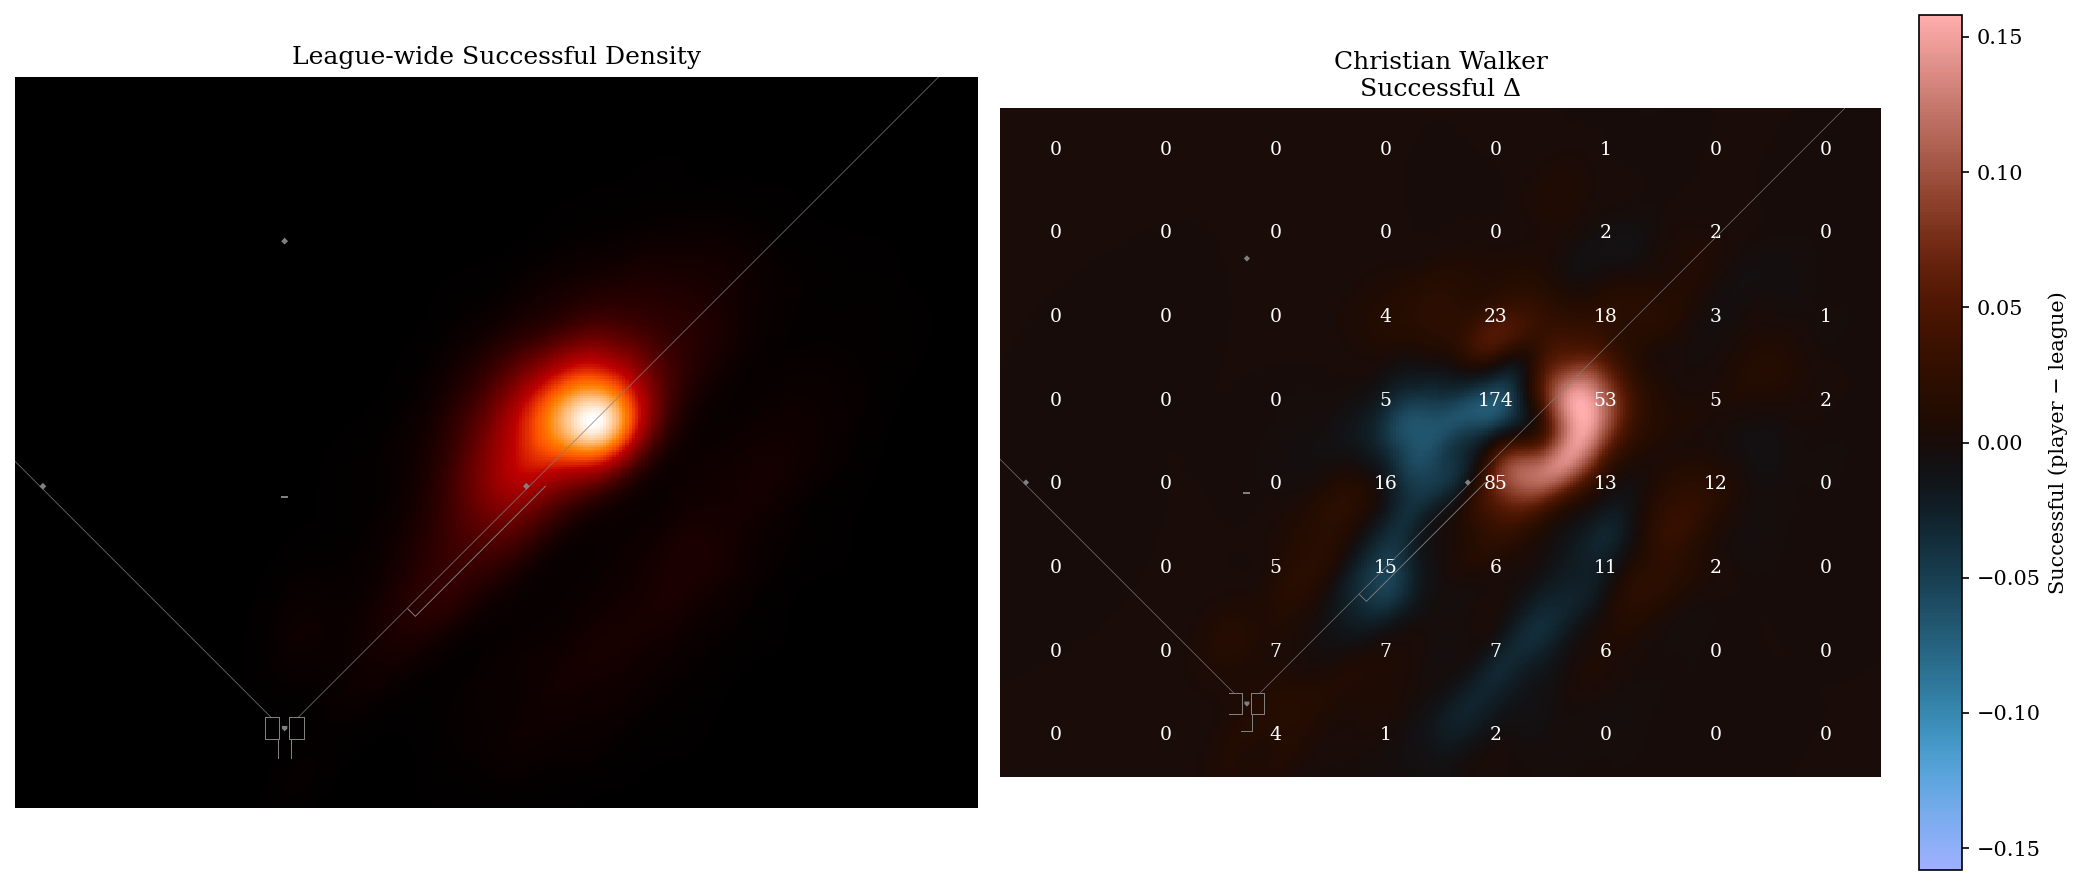

In [6]:
plot_1b_play_heatmap(fb, "Christian Walker", outcome='successful', mesh_size=300, grid_n=8, grid_color='white', grid_linewidth=0)

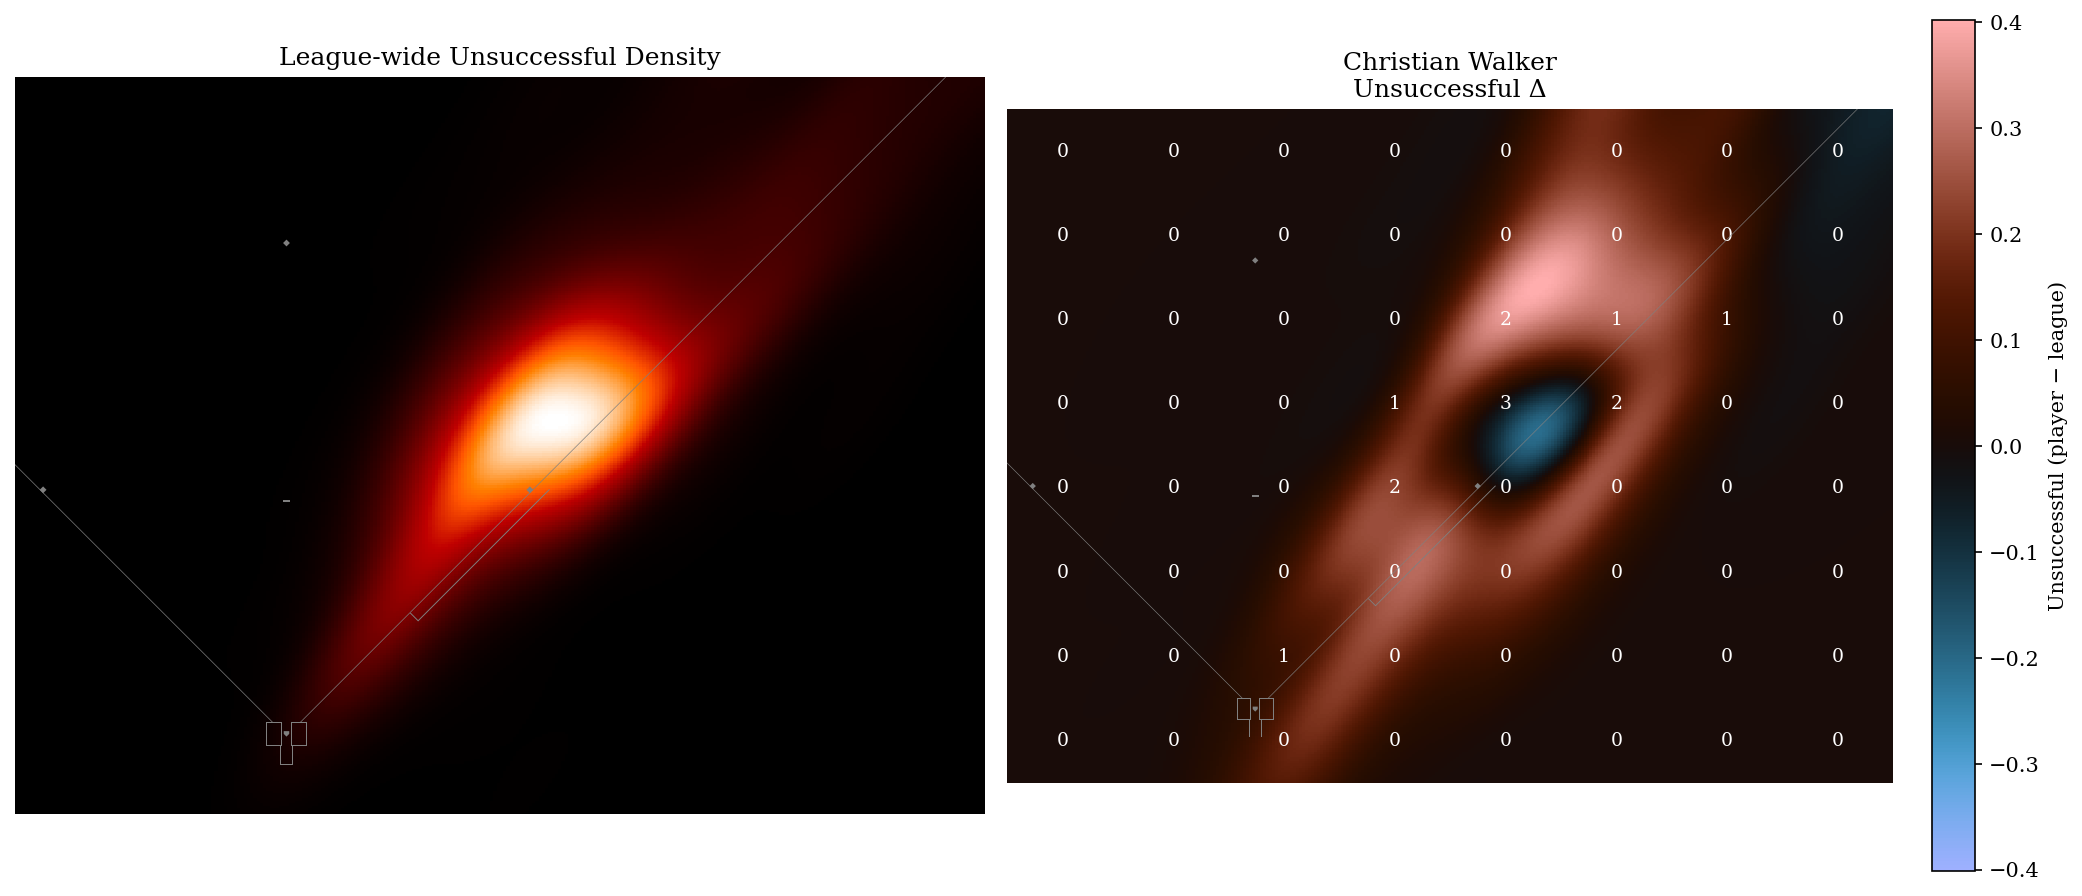

In [7]:
plot_1b_play_heatmap(fb, "Christian Walker", outcome='unsuccessful', mesh_size=300, grid_n=8, grid_color='white', grid_linewidth=0)

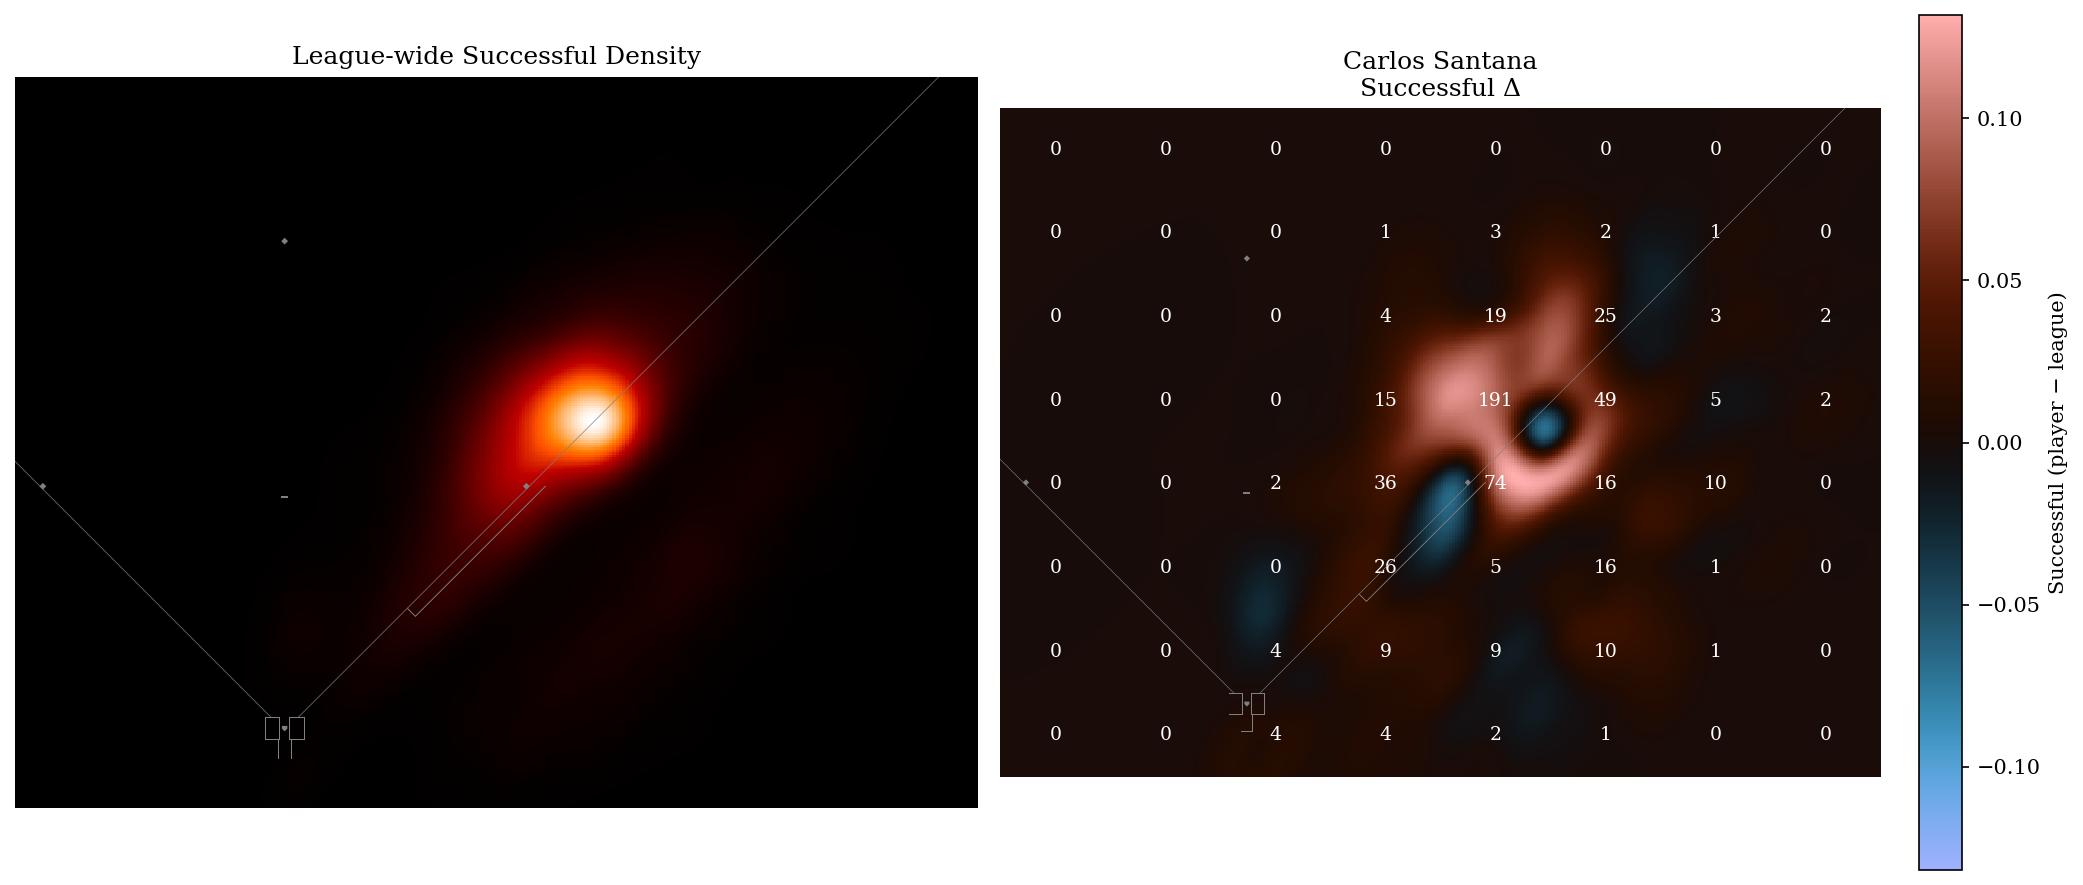

In [8]:
plot_1b_play_heatmap(fb, "Carlos Santana", outcome='successful', mesh_size=300, grid_n=8, grid_color='white', grid_linewidth=0)

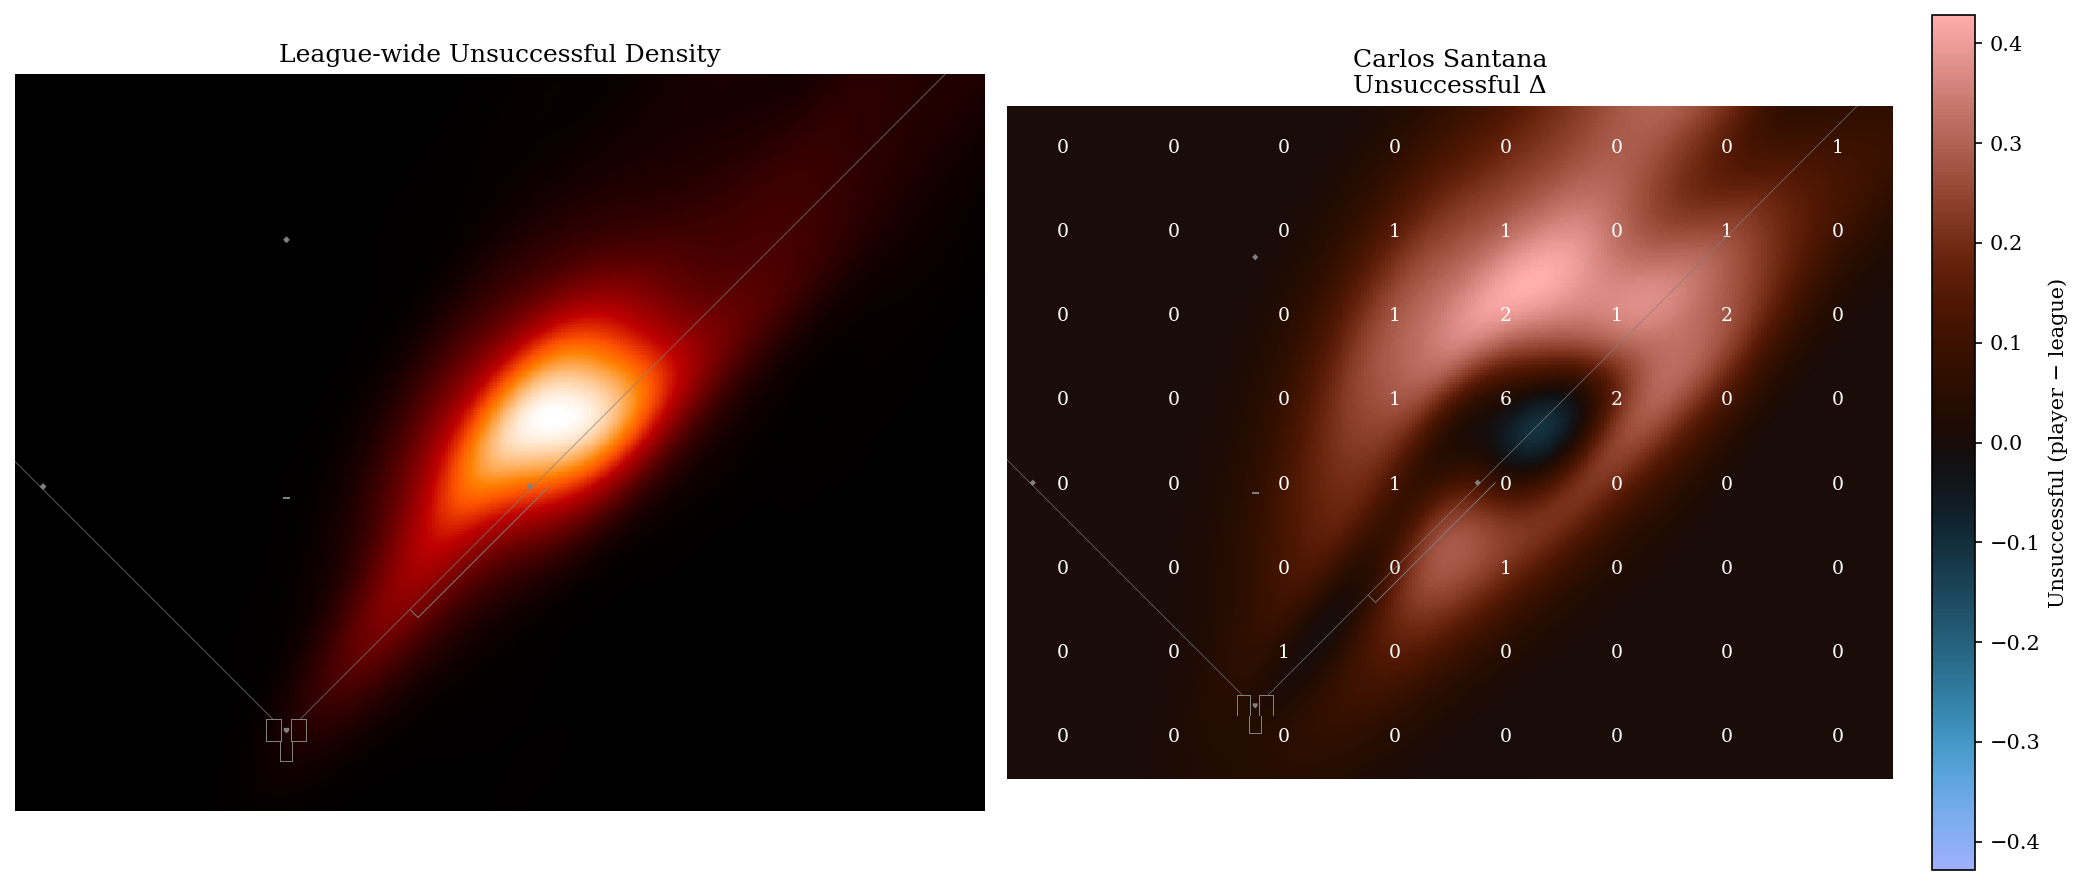

In [9]:
plot_1b_play_heatmap(fb, "Carlos Santana", outcome='unsuccessful', mesh_size=300, grid_n=8, grid_color='white', grid_linewidth=0)

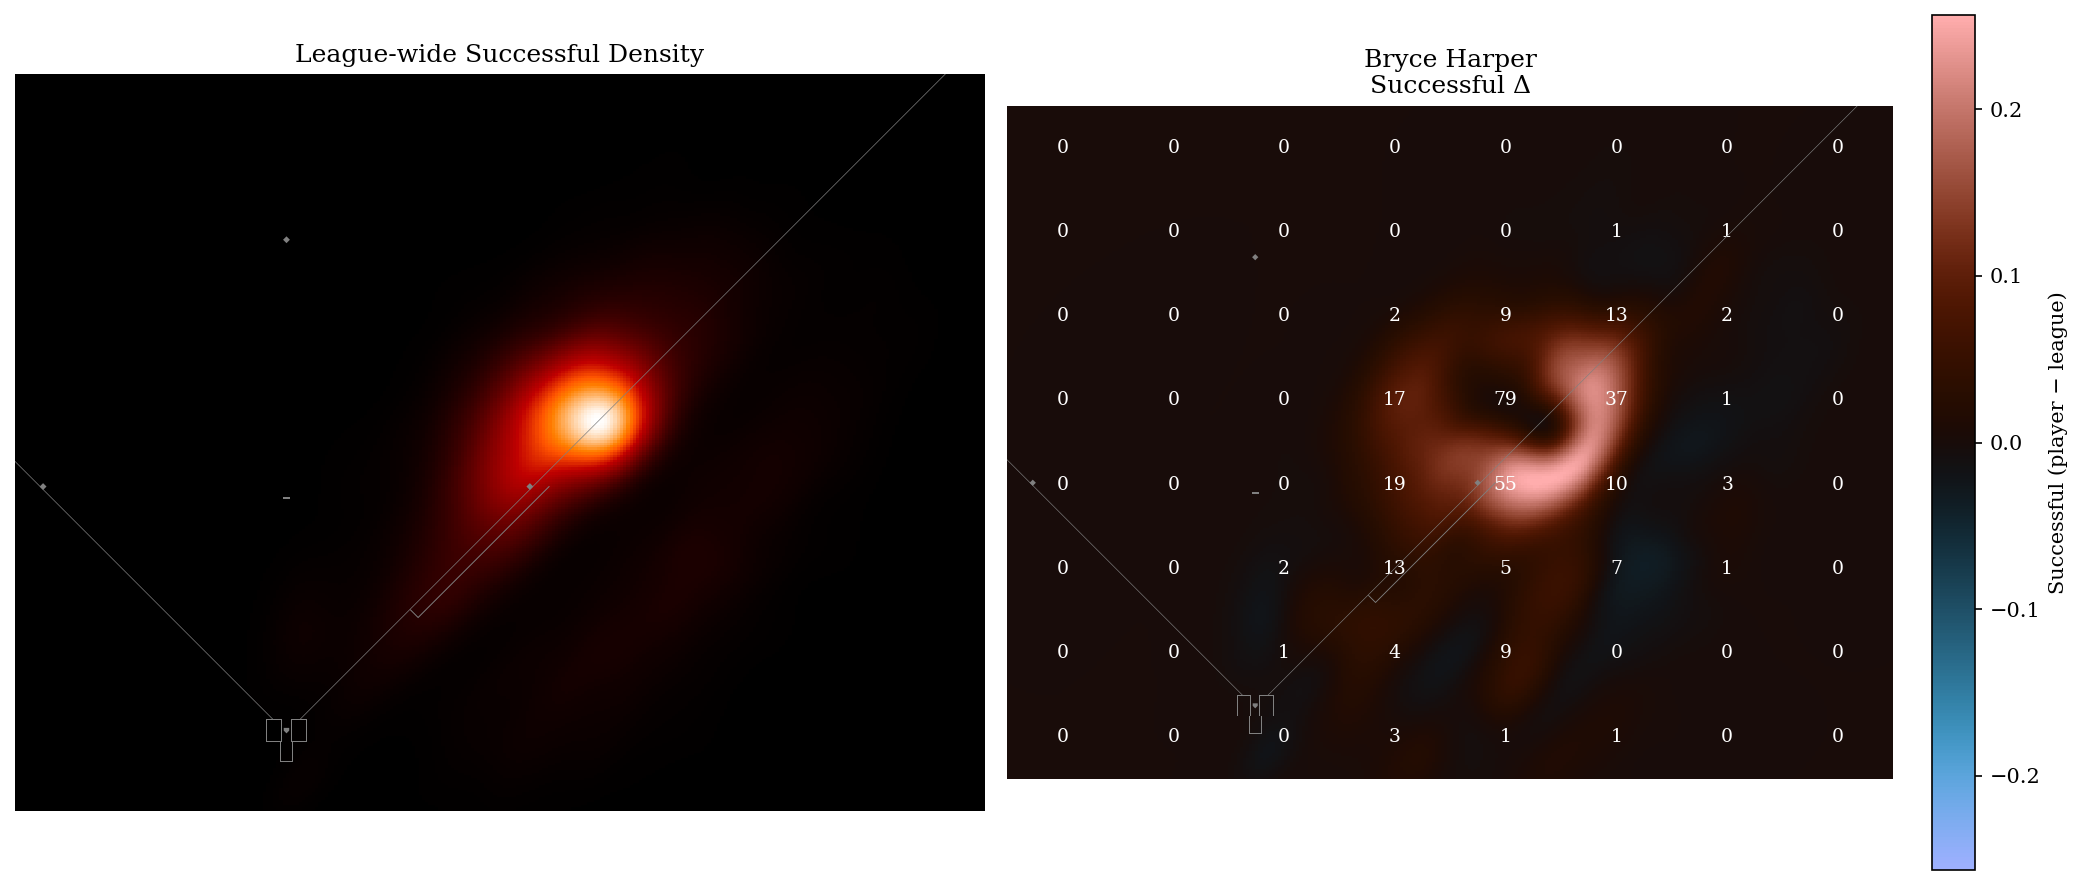

In [10]:
plot_1b_play_heatmap(fb, "Bryce Harper", outcome='successful', mesh_size=300, grid_n=8, grid_color='white', grid_linewidth=0)

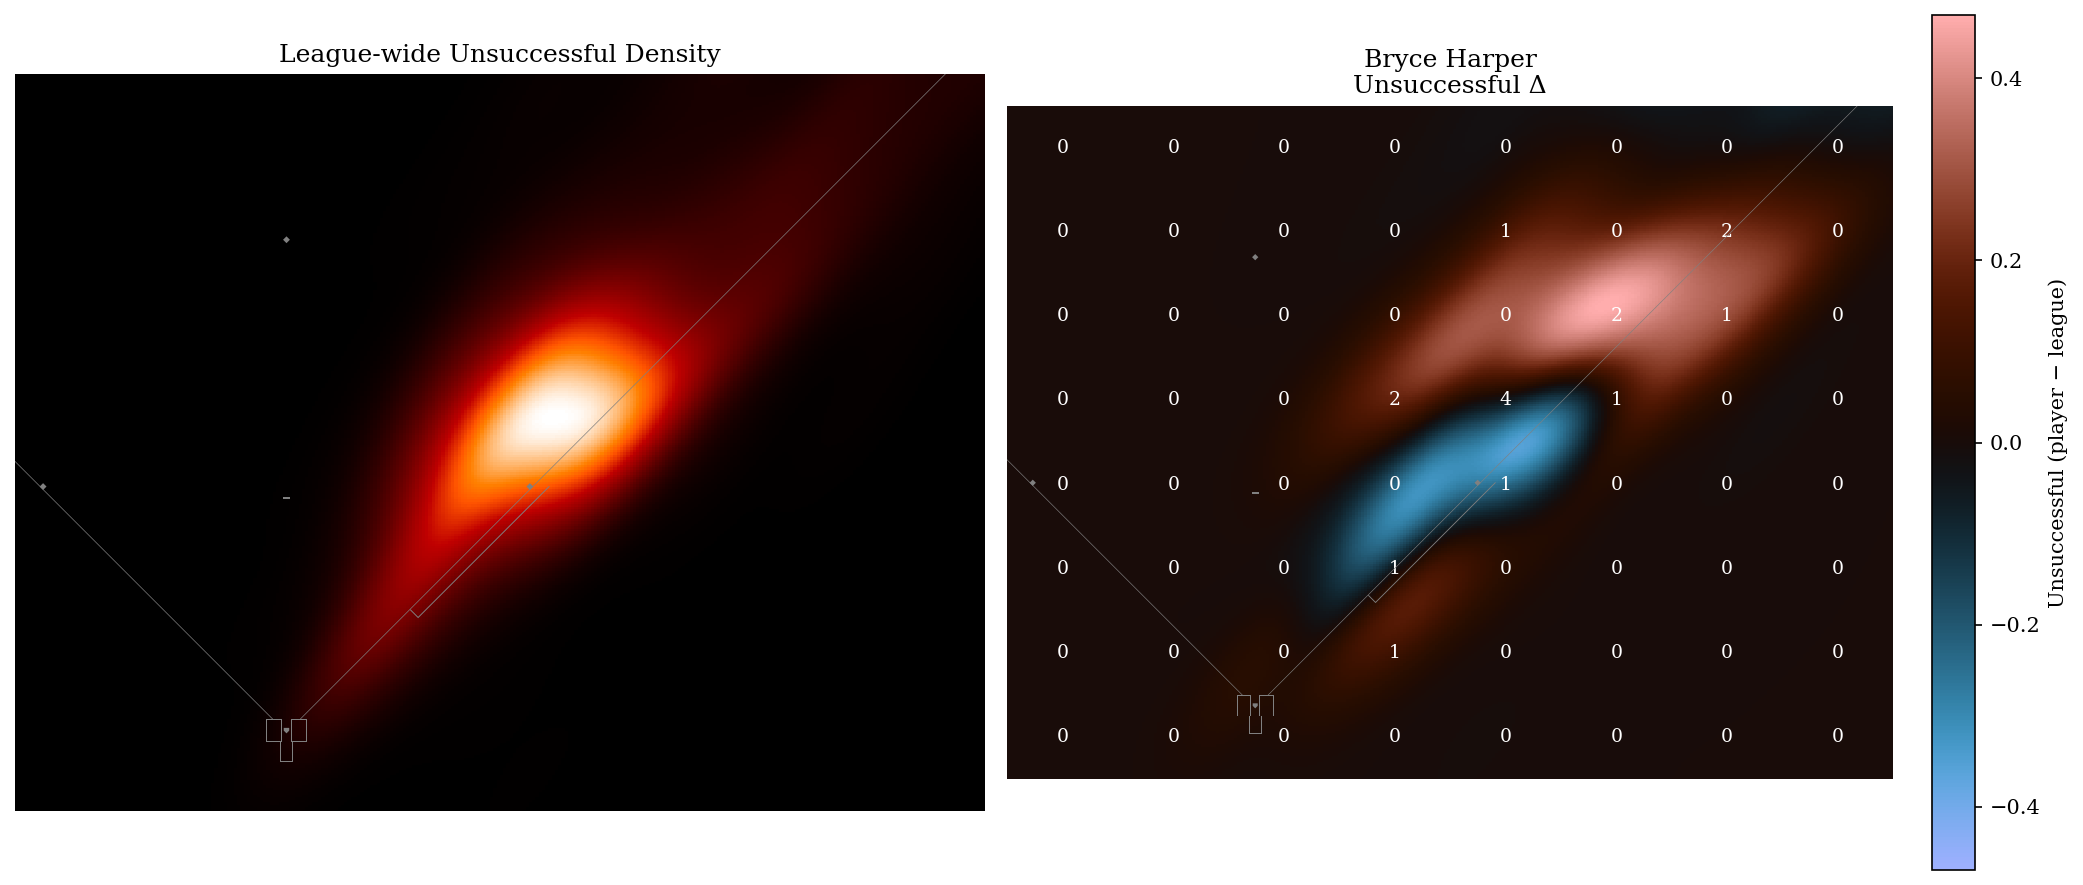

In [11]:
plot_1b_play_heatmap(fb, "Bryce Harper", outcome='unsuccessful', mesh_size=300, grid_n=8, grid_color='white', grid_linewidth=0)

#### So, we have a good start at comparing locations or directions where players struggle to field hits. Of course, with higher-level players (and as you can see in the plots) there aren't going to many unsuccessful plays to begin with.

#### And further filtering and comparison (type of hit, velocity...) will be really interesting.